In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data (replace with your path if needed)
career_stats = pd.read_csv("nba_career_stats.csv")

# Step 1: Clean and filter
career_stats.columns = career_stats.columns.str.strip()
career_filtered = career_stats[(career_stats['TEAM_ID'] != 0) & (career_stats['GP'] > 0)].copy()


career_filtered['BPM_Lite'] = (
    (career_filtered['AST'] * 0.58 + career_filtered['STL'] * 1.369 + career_filtered['BLK'] * 1.327 +
     career_filtered['REB'] + career_filtered['PTS'] * 0.86 -
     career_filtered['TOV'] * 0.964 - career_filtered['PF'] * 0.367) / career_filtered['GP']
)

# Step 3: Average performance per player
player_perf = career_filtered.groupby('Player')[['PER_Lite', 'BPM_Lite']].mean().reset_index()

# Step 4: Count unique teams (for trade count)
team_counts = (
    career_filtered.groupby('Player')['TEAM_ID']
    .nunique()
    .reset_index()
    .rename(columns={'TEAM_ID': 'Unique_Teams_Played_For'})
)
team_counts['Times_Traded'] = team_counts['Unique_Teams_Played_For'] - 1

# Step 5: Merge and classify stability
player_summary = pd.merge(player_perf, team_counts, on='Player')
player_summary['Stability'] = player_summary['Times_Traded'].apply(lambda x: 'Stable' if x <= 1 else 'Unstable')

# Step 6: Compare groups
stability_comparison = player_summary.groupby('Stability')[['PER_Lite', 'BPM_Lite']].mean().reset_index()

# Step 7: Display results
print("\n=== Stability Comparison ===")
print(stability_comparison)

print("\n=== Sample of Player-Level Summary ===")
print(player_summary.head(10))

In [ ]:
import pandas as pd

# Load the merged file (or use existing merged variable)
merged = pd.read_csv("merged_sorted_by_traded_status_5.csv")
merged.columns = merged.columns.str.strip()

# Calculate custom BPM column (skip rows with GP = 0 to avoid division errors)
merged['Custom_BPM'] = (
    (merged['AST'] * 0.58 + merged['STL'] * 1.369 + merged['BLK'] * 1.327 +
     merged['REB'] + merged['PTS'] * 0.86 -
     merged['TOV'] * 0.964 - merged['PF'] * 0.367) / merged['GP']
)

# Replace infinite or undefined values (if any GP = 0 slipped through)
merged['Custom_BPM'] = merged['Custom_BPM'].replace([float('inf'), -float('inf')], pd.NA)

# Save updated file
merged.to_csv("merged_with_custom_bpm.csv", index=False)

print("✅ Custom BPM column added and saved to merged_with_custom_bpm.csv")


In [ ]:
import pandas as pd

# Load merged data that includes Custom_BPM and Traded_Status
merged = pd.read_csv("merged_with_custom_bpm.csv")
merged.columns = merged.columns.str.strip()

bpm_stats = merged.groupby('PLAYER_NAME')['Custom_BPM'].agg(
    Custom_BPM_Mean='mean',
    Custom_BPM_StdDev='std'
).reset_index()

# Step 2: Get one unique Traded_Status per player
traded_status = merged[['PLAYER_NAME', 'Traded_Status']].drop_duplicates(subset='PLAYER_NAME')

# Step 3: Merge stats and traded status
summary = pd.merge(bpm_stats, traded_status, on='PLAYER_NAME', how='left')

# Step 4: Save to CSV
summary.to_csv("player_bpm_stats_with_traded_status.csv", index=False)

print("✅ Saved as player_bpm_stats_with_traded_status.csv")


In [ ]:
df_cleaned = df.dropna(subset=["MIN", "PTS", "AST", "REB", ...])

# Group by PLAYER_ID to get total/career-level data
player_summary = df_cleaned.groupby("PLAYER_ID").agg({
    "Player": "first",
    "TEAM_ID": pd.Series.nunique,     # proxy for trade_count
    "PTS": "sum",
    "AST": "sum",
    "REB": "sum",
    "GP": "sum",
    "PLAYER_AGE": "mean",
    # + any others
}).rename(columns={"TEAM_ID": "trade_count"})


In [9]:
import pandas as pd
import unicodedata
# Load both datasets
career_df = pd.read_csv("nba_career_stats.csv")
draft_df = pd.read_csv("nba_draft_picks.csv") 

def strip_accents(text):
    if isinstance(text, str):
        return ''.join(
            c for c in unicodedata.normalize('NFKD', text)
            if not unicodedata.combining(c)
        )
    return text


draft_df = draft_df.rename(columns={"PLAYER_NAME": "Player"})

career_df['Player'] = career_df['Player'].apply(strip_accents).str.strip().str.lower()
draft_df['Player'] = draft_df['Player'].apply(strip_accents).str.strip().str.lower()



merged = pd.merge(career_df, draft_df, on="Player", how="inner")

merged = merged[merged["ROUND_NUMBER"] == 1]

# Drop rows with missing required stats
merged = merged.dropna(subset=["AST", "STL", "BLK", "REB", "PTS", "TOV", "PF", "GP"])
merged = merged[merged["GP"] > 0]  # Avoid division by zero

# Compute your custom BPM
merged['Custom_BPM'] = (
    (merged['AST'] * 0.58 +
     merged['STL'] * 1.369 +
     merged['BLK'] * 1.327 +
     merged['REB'] +
     merged['PTS'] * 0.86 -
     merged['TOV'] * 0.964 -
     merged['PF'] * 0.367) / merged['GP']
)

# Extract season year
merged["SEASON_YEAR"] = merged["SEASON_ID"].str[:4].astype(int)

# Calculate experience
merged["Years_In_League"] = merged["SEASON_YEAR"] - merged["Draft Year"]

# Final cleaned dataset
cleaned_first_round_df = merged.reset_index(drop=True)
output_path = "cleaned_first_round_players.csv"
cleaned_first_round_df.to_csv(output_path, index=False)
output_path


'cleaned_first_round_players.csv'

In [11]:
cleaned_first_round_df = cleaned_first_round_df.sort_values(by=["Player", "SEASON_YEAR"]).reset_index(drop=True)

cleaned_first_round_df["team_changed"] = (
    cleaned_first_round_df.groupby("Player")["TEAM_ID_x"]
    .transform(lambda x: x != x.shift()).astype(int)
)

cleaned_first_round_df["trade_count_so_far"] = (
    cleaned_first_round_df.groupby("Player")["team_changed"].cumsum() - 1
).clip(lower=0)

cleaned_first_round_df.drop(columns=["team_changed"], inplace=True)

final_path = "first_round_with_fixed_trade_count.csv"
cleaned_first_round_df.to_csv(final_path, index=False)

final_path


'first_round_with_fixed_trade_count.csv'

In [14]:
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Select features and target
features = [
    "trade_count_so_far",
    "Years_In_League",
    "PLAYER_AGE",
    "PTS",
    "AST",
    "REB",
    "GP"
]
target = "Custom_BPM"

model_df = cleaned_first_round_df.dropna(subset=features + [target])

X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
coefficients = dict(zip(features, lr_model.coef_))

{
    "Mean Squared Error": round(mse, 4),
    "R² Score": round(r2, 4),
    "Intercept": round(lr_model.intercept_, 4),
    "Coefficients": coefficients
}

joblib.dump(lr_model, "model.pkl")

['model.pkl']

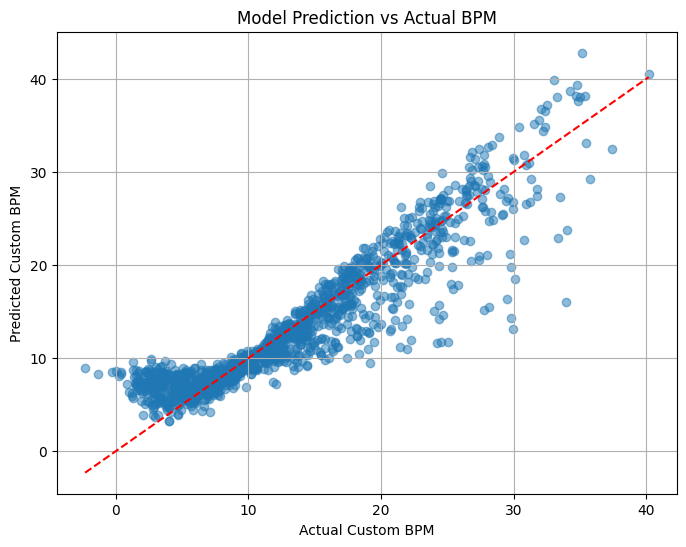

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Custom BPM")
plt.ylabel("Predicted Custom BPM")
plt.title("Model Prediction vs Actual BPM")
plt.grid(True)
plt.show()
